# Assignment 2 : Supervised Learning

## Import necessary libraries

In [1]:
# load basic libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

# load libraries related to model building and evaluation

from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# suppress warnings

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# creating data frame to capture evaluation output of all models
modelevalcompdf = pd.DataFrame(columns=['Model','Featurebasis','MCC','Accuracy','ROCAUC','PRAUC','CM','Class0-Precision','Sensitivity','Class0-F1','Class1-Precision','Specificity','Class1-F1'])



## Load Data

In [3]:
# data is loaded to 2 dataframes. rawdata and mydata. 
#rawdata will represent the original data and mydata will be updated for transformations

myfile = "Bank_Personal_Loan_Modelling-1.csv"
rawdata = pd.read_csv(myfile) 
mydata = pd.read_csv(myfile)
mydata.sample(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
880,881,57,31,58,91604,1,0.2,1,177,0,0,0,1,0
442,443,58,28,122,95136,1,3.0,3,115,1,0,0,1,0
2112,2113,27,2,103,93117,1,1.9,1,120,0,0,0,1,0
3733,3734,58,32,72,94105,3,0.3,2,0,0,0,0,1,0
2183,2184,34,8,29,90025,2,2.0,3,0,0,0,0,1,1


## EDA, Attribute Analysis

In [4]:
# creating function for counting outliers
def outliercount(attr,df):
    Q1 = df[attr].quantile(0.25)
    Q3 = df[attr].quantile(0.75)
    IQR = Q3-Q1
    
    if Q1!=0 or Q3!=0:
        outlier_count=((df[attr]<(Q1-(1.5*IQR))) | (df[attr]>(Q3+(1.5*IQR)))).sum()
    else:
        outlier_count=''
        
    return outlier_count

# EDA using custom built dataframe

Item=[]
for attr in mydata.columns:
    Item.append([
        attr,mydata[attr].dtype,
        mydata[attr].isna().sum(),
        round((mydata[attr].isna().sum()/len(mydata[attr]))*100,2),
        mydata[attr].nunique(),
        list(mydata[attr].sample(5).drop_duplicates().values),
        mydata[attr].count(),
        len(mydata[mydata[attr]<0]),
        mydata[attr].std(),
        mydata[attr].min(),
        mydata[attr].quantile(.25),
        mydata[attr].quantile(.50),
        mydata[attr].mean(),
        mydata[attr].quantile(0.75),
        mydata[attr].max(),
        mydata[attr].skew(),
        outliercount(attr,mydata)  
    ]);
    
eda=pd.DataFrame(data=Item,columns=['Attribute','Datatype','Null','Null%','Unique','Sample','Count','-Ve Data','Stddev','Min','25%','50%','Mean','75%','Max','Skew','No.# Outlier'])

eda.round(2)

,Attribute,Datatype,Null,Null%,Unique,Sample,Count,-Ve Data,Stddev,Min,25%,50%,Mean,75%,Max,Skew,No.# Outlier
0,ID,int64,0,0.0,5000,"[1704, 3133, 2859, 472, 3780]",5000,0,1443.52,1.0,1250.75,2500.5,2500.50,3750.25,5000.0,0.00,0
1,Age,int64,0,0.0,45,"[57, 31, 54, 49, 29]",5000,0,11.46,23.0,35.00,45.0,45.34,55.00,67.0,-0.03,0
2,Experience,int64,0,0.0,47,"[34, 0, 5, 27, 41]",5000,52,11.47,-3.0,10.00,20.0,20.10,30.00,43.0,-0.03,0
3,Income,int64,0,0.0,162,"[38, 79, 114, 35, 141]",5000,0,46.03,8.0,39.00,64.0,73.77,98.00,224.0,0.84,96
4,ZIP Code,int64,0,0.0,467,"[90401, 94305, 94402, 95138, 94132]",5000,0,2121.85,9307.0,91911.00,93437.0,93152.50,94608.00,96651.0,-12.50,1
5,Family,int64,0,0.0,4,"[2, 4, 1]",5000,0,1.15,1.0,1.00,2.0,2.40,3.00,4.0,0.16,0
6,CCAvg,float64,0,0.0,108,"[0.1, 2.1, 1.6, 0.7, 1.0]",5000,0,1.75,0.0,0.70,1.5,1.94,2.50,10.0,1.60,324
7,Education,int64,0,0.0,3,"[1, 2]",5000,0,0.84,1.0,1.00,2.0,1.88,3.00,3.0,0.23,0
8,Mortgage,int64,0,0.0,347,"[153, 0, 91, 251, 107]",5000,0,101.71,0.0,0.00,0.0,56.50,101.00,635.0,2.10,291
9,Personal Loan,int64,0,0.0,2,[0],5000,0,0.29,0.0,0.00,0.0,0.10,0.00,1.0,2.74,


#### Based on the above we can infer the following:

#1.There is no missing data.
#2.Categorical variables are already represented in integer and hence there is no need for one hot encoding.
#3.'Experience' column has 52 records with negative data. This needs to be cleaned.
#4.ID and Zipcode are not relevant for further analysis and can be dropped. Zipcode has 1 outlier data.
#5.Outliers are there in Income,Mortgage and CCAvg. Depending on further analysis,we may need to do log transformation.

In [5]:
# Since the Personal Loan is the target column for this analysis, rearranging the column sequence in the data frame 
#such that target column is the last column

mydata= mydata[[ 'Age', 'Experience', 'Income','ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Securities Account',
       'CD Account', 'Online', 'CreditCard', 'Personal Loan']]


mydata.sample(10)

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
1490,30,4,18,95020,4,0.30,2,0,0,0,1,1,0
670,23,-1,61,92374,4,2.60,1,239,0,0,1,0,0
3981,64,39,22,92691,3,0.50,1,0,1,1,1,1,0
2808,53,27,35,94583,3,0.90,3,136,0,0,1,0,0
1070,36,9,40,90840,2,1.00,2,0,0,0,1,0,0
3972,29,5,112,94998,2,4.33,1,0,0,0,1,1,0
3328,45,20,22,90230,1,0.10,1,0,0,0,0,0,0
1256,31,7,20,92115,1,0.40,3,0,0,0,1,0,0
890,55,29,29,92780,4,1.50,3,79,0,0,1,0,0
4295,65,41,91,91360,2,0.00,3,146,0,0,0,0,0


Skewness of Age distribution = -0.03


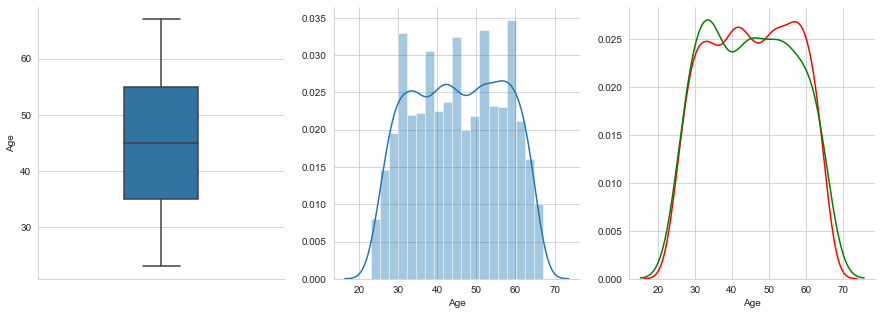

In [6]:
# Analysis of Attribute: Age
curattr = 'Age'
f,axes = plt.subplots(1,3)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Personal Loan'] == 0][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Personal Loan'] == 1][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)
curattr_skew = mydata[curattr].skew()
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )

#### Based on the above we can infer the following - Inference for Attribute: Age

#1.There are no outliers.
#2.Mean and Median are close.Data seems to be fairly normally distributed. Multiple gaussians noted
#3.There is highly significant overlap of classes for customers who have taken Personal Loan and those who have not taken Personal Loan across age. This suggests that 'Age' may not be a significant factor in determining whether a customer will take personal loan or not.


In [7]:
# Analysis of Attribute: Experience

# EDA showed 52 records of -ve data for experience.

print(len(mydata[mydata['Experience'] < 0]))

52


In [8]:
# one possible assumption based approach is to consider the experience data for these records as positive value 
# as this seems to be consistent with the age.

mydata['Experience'] = abs(mydata['Experience'])

Skewness of Experience distribution = -0.01


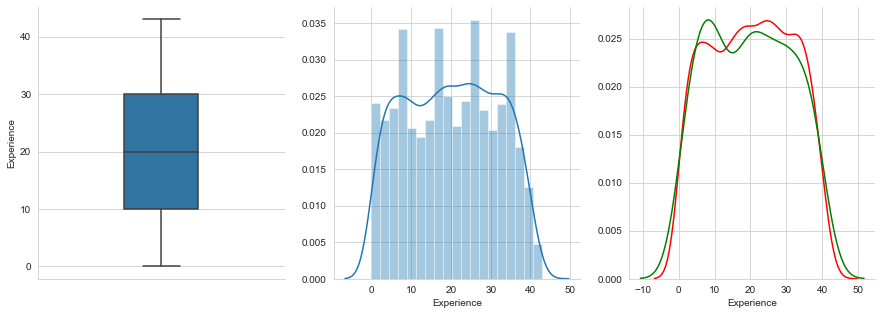

In [9]:
# Analysis of Experience post data correction

curattr = 'Experience'
f,axes = plt.subplots(1,3)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Personal Loan'] == 0][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Personal Loan'] == 1][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)
curattr_skew = mydata[curattr].skew()
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )

#### Based on the above we can infer the following - Inference for Attribute: Experience

#1.There are no outliers. Records with negative data corrected with assumption.
#2.Mean and Median are close.Data seems to be fairly normally distributed. Multiple gaussians noted
#3.There is highly significant overlap of classes for customers who have taken Personal Loan and those who have not taken Personal Loan across experience years. This suggests that 'Experience' may not be a significant factor in determining whether a customer will take personal loan or not.


Skewness of Income distribution = 0.84


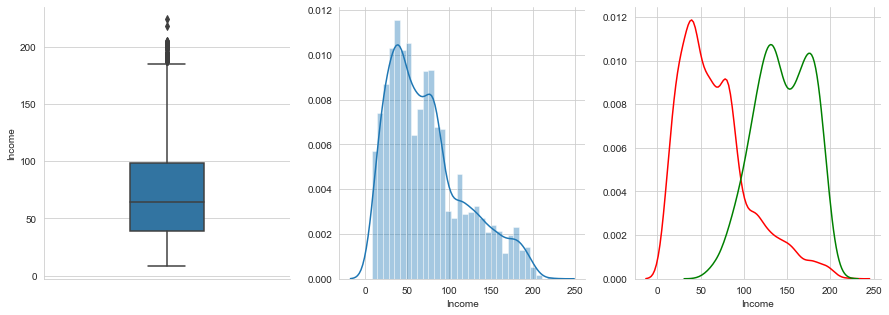

In [10]:
# Analysis of Attribute: Income
curattr = 'Income'
f,axes = plt.subplots(1,3)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Personal Loan'] == 0][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Personal Loan'] == 1][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)
curattr_skew = mydata[curattr].skew()
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )

#### Based on the above we can infer the following - Inference for Attribute: Income

#1.There are outliers.Count of Outliers is 96. We can assume that the impact of these outliers is not significant to warrant log transformation.
#2.Mean and Median are not close.Data seems to be skewed. Multiple gaussians noted
#3.There is a reasonable overlap of classes for customers who have taken Personal Loan and those who have not taken Personal Loan in certain range of Income. As the Income increases, probability of customers taking personal loan also increases.


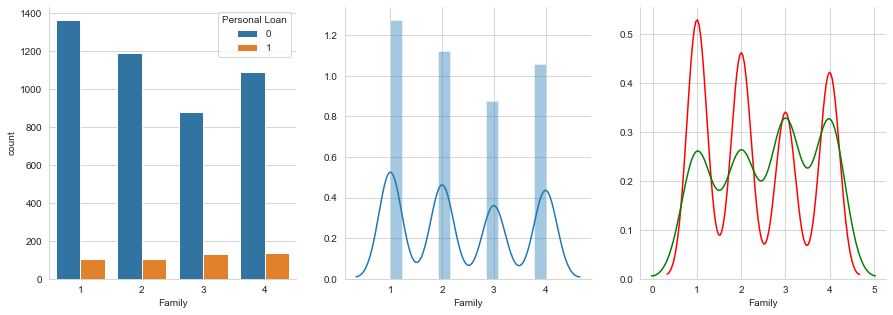

In [11]:
# Analysis of Attribute: Family
curattr = 'Family'
f,axes = plt.subplots(1,3)
sns.countplot(x = mydata[curattr],hue = 'Personal Loan',data = mydata, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Personal Loan'] == 0][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Personal Loan'] == 1][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)

#### Based on the above we can infer the following - Inference for Attribute: Family

#1.There is a significant overlap of classes for customers who have taken Personal Loan and those who have not taken Personal Loan across all family sizes.



Skewness of CCAvg distribution = 1.60


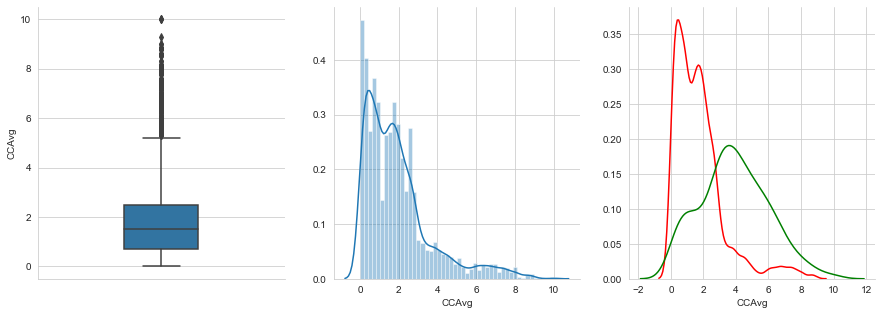

In [12]:
# Analysis of Attribute: CCAvg
curattr = 'CCAvg'
f,axes = plt.subplots(1,3)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Personal Loan'] == 0][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Personal Loan'] == 1][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)
curattr_skew = mydata[curattr].skew()
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )

#### Based on the above we can infer the following - Inference for Attribute: CCAvg

#1.There are outliers.These 324 outliers seems to affect the distribution and hence log transformation can be deployed.
#2.Mean and Median are not close.Data seems to be skewed. Multiple gaussians noted
#3.There is a reasonable overlap of classes for customers who have taken Personal Loan and those who have not taken Personal Loan . Customer with higher CCAvg spending are more likely to take personal loan.



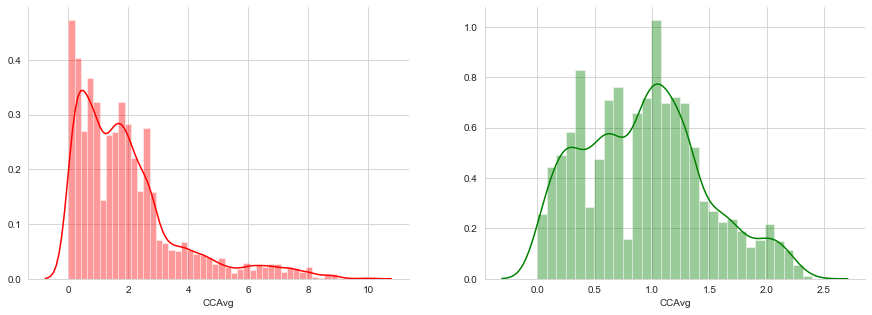

In [13]:
# Log transformation for CCAvg
logccavg = np.log1p(mydata.CCAvg)

f,axes = plt.subplots(1,2)

sns.distplot(mydata.CCAvg,color='r',ax = axes[0],label='With orginal data')
sns.distplot(logccavg,color='g',ax = axes[1],label='With transformed data')
sns.despine()
plt.gcf().set_size_inches(15, 5)

In [14]:
# based on the above, mydata dataframe is updated for CCAvg with transformed data
mydata['CCAvg'] = logccavg

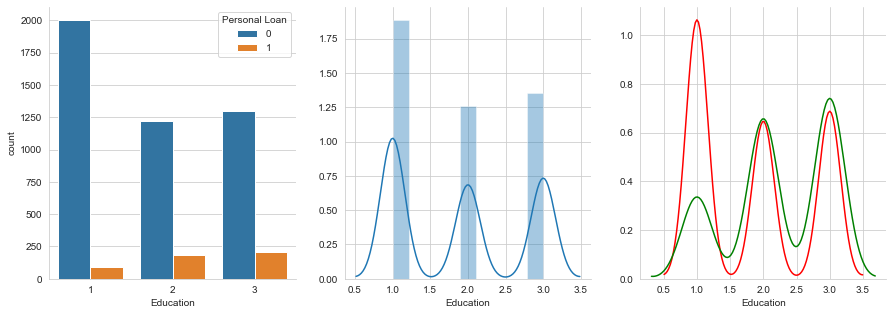

In [15]:
# Analysis of Attribute: Education
curattr = 'Education'
f,axes = plt.subplots(1,3)
sns.countplot(x = mydata[curattr],hue = 'Personal Loan',data = mydata, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Personal Loan'] == 0][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Personal Loan'] == 1][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)

#### Based on the above we can infer the following - Inference for Attribute: Education
#1.There is a significant overlap of classes for customers who have taken Personal Loan and those who have not taken Personal Loan across all customers with different education levels.
#2.With customers having education level above 1, the proportion of customers taking personal loan is higher than those with education level 1.
#3.Data is marginally skewed towards those with education level 1.




Skewness of Mortgage distribution = 2.10


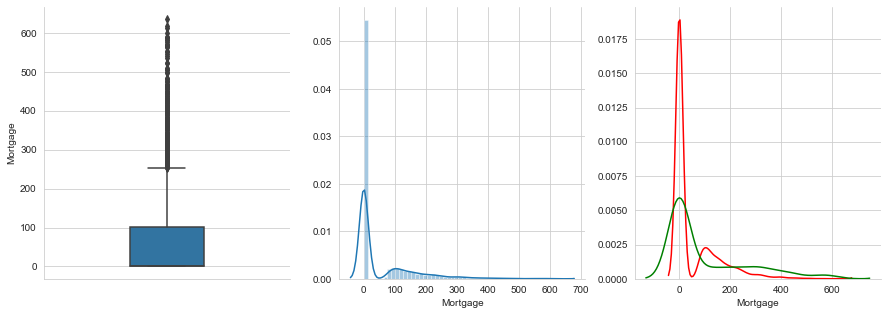

In [16]:
# Analysis of Attribute: Mortgage
curattr = 'Mortgage'
f,axes = plt.subplots(1,3)
sns.boxplot(x = mydata[curattr],orient = 'v',data = mydata,width=.3, ax = axes[0])
sns.distplot( mydata[curattr],ax = axes[1])
sns.distplot( mydata[mydata['Personal Loan'] == 0][curattr],hist = False,color = 'r',ax = axes[2])
sns.distplot( mydata[mydata['Personal Loan'] == 1][curattr],hist = False,color = 'g',ax = axes[2])
sns.despine()
plt.gcf().set_size_inches(15, 5)
curattr_skew = mydata[curattr].skew()
print('Skewness of ' + curattr +' distribution = %1.2f' %(curattr_skew) )

#### Based on the above we can infer the following - Inference for Attribute: Mortgage

#1.There are outliers.These 291 outliers seems to affect the distribution and hence log transformation can be deployed to correct this
#2.Mean and Median are not close.Data seems to be skewed. 
#3.There is overlap of classes for customers who have taken Personal Loan and those who have not taken Personal Loan across all mortgage levels. Those with higher mortgage levels are more likely to take personal loan.

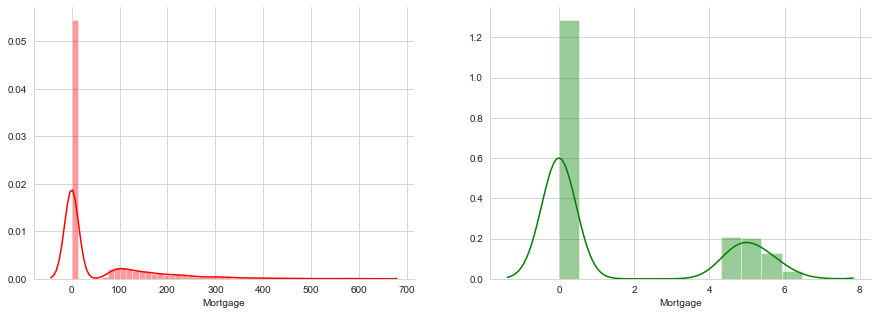

In [17]:
# Log transformation for Mortgage
logmortgage = np.log1p(mydata.Mortgage)

f,axes = plt.subplots(1,2)

sns.distplot(mydata.Mortgage,color='r',ax = axes[0],label='With orginal data')
sns.distplot(logmortgage,color='g',ax = axes[1],label='With transformed data')
sns.despine()
plt.gcf().set_size_inches(15, 5)

In [18]:
# based on the above, mydata dataframe is updated for Mortgage with transformed data
mydata['Mortgage'] = logmortgage

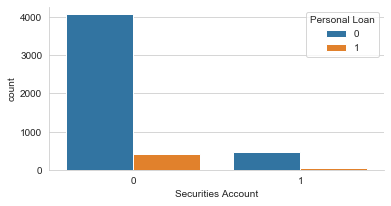

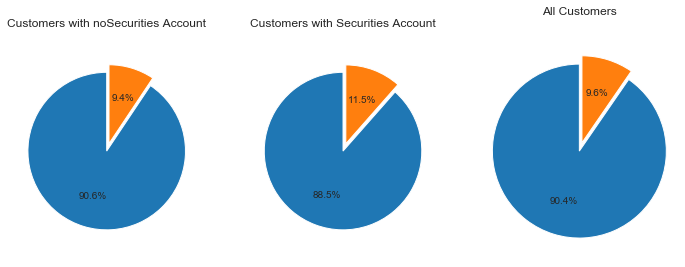

In [19]:
# Analysis of Attribute: Securities Account
curattr = 'Securities Account'
sns.countplot(x = mydata[curattr],hue = 'Personal Loan',data = mydata)
sns.despine()
plt.gcf().set_size_inches(6, 3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4),subplot_kw=dict(aspect="equal"))
plt.axis('equal')

ax1.pie(mydata[mydata[curattr] == 0]['Personal Loan'].value_counts(), autopct= '%1.1f%%', explode = (0, 0.1), radius = 1, startangle = 90)
ax1.set_title('Customers with no'+curattr,fontsize = 12, y = 1.1)
ax2.pie(mydata[mydata[curattr] == 1]['Personal Loan'].value_counts(), autopct= '%1.1f%%',explode = (0, 0.1), radius = 1, startangle = 90)
ax2.set_title('Customers with '+curattr, fontsize = 12, y = 1.1);
ax3.pie(mydata['Personal Loan'].value_counts(), autopct= '%1.1f%%',explode = (0, 0.1), radius = 1, startangle = 90)
ax3.set_title('All Customers', fontsize = 12, y = 1.1);


#### Based on the above we can infer the following - Inference for Attribute: Securities Account

#1.There is a significant overlap of classes for customers who have taken Personal Loan and those who have not taken Personal Loan .
#2.Proportion of customers who take personal loan is marginally higher in cases where customer has Securities account.
#3.Data is highly skewed towards those without securities account.

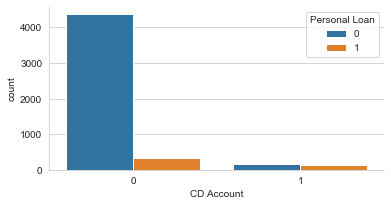

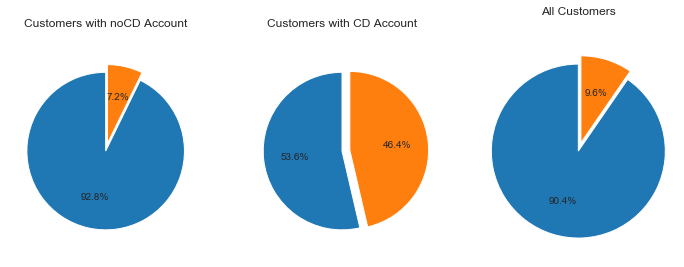

In [20]:
# Analysis of Attribute: CD Account
curattr = 'CD Account'
sns.countplot(x = mydata[curattr],hue = 'Personal Loan',data = mydata)
sns.despine()
plt.gcf().set_size_inches(6, 3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4),subplot_kw=dict(aspect="equal"))
plt.axis('equal')

ax1.pie(mydata[mydata[curattr] == 0]['Personal Loan'].value_counts(), autopct= '%1.1f%%', explode = (0, 0.1), radius = 1, startangle = 90)
ax1.set_title('Customers with no'+curattr,fontsize = 12, y = 1.1)
ax2.pie(mydata[mydata[curattr] == 1]['Personal Loan'].value_counts(), autopct= '%1.1f%%',explode = (0, 0.1), radius = 1, startangle = 90)
ax2.set_title('Customers with '+curattr, fontsize = 12, y = 1.1);
ax3.pie(mydata['Personal Loan'].value_counts(), autopct= '%1.1f%%',explode = (0, 0.1), radius = 1, startangle = 90)
ax3.set_title('All Customers', fontsize = 12, y = 1.1);

#### Based on the above we can infer the following - Inference for Attribute: CD Account

#1.There is a significant overlap of classes for customers who have taken Personal Loan and those who have not taken Personal Loan .
#2.Data is highly skewed towards those without CD account.
#3.Proportion of customers taking personal loan is close to 47%, among those with CD account. Customers with CD account are more likely to take personal loan.



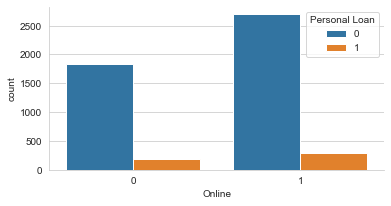

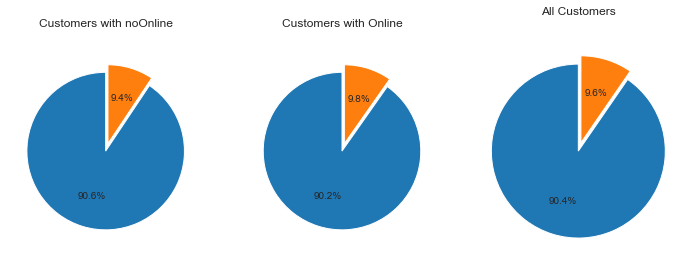

In [21]:
# Analysis of Attribute: Online
curattr = 'Online'
sns.countplot(x = mydata[curattr],hue = 'Personal Loan',data = mydata)
sns.despine()
plt.gcf().set_size_inches(6, 3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4),subplot_kw=dict(aspect="equal"))
plt.axis('equal')

ax1.pie(mydata[mydata[curattr] == 0]['Personal Loan'].value_counts(), autopct= '%1.1f%%', explode = (0, 0.1), radius = 1, startangle = 90)
ax1.set_title('Customers with no'+curattr,fontsize = 12, y = 1.1)
ax2.pie(mydata[mydata[curattr] == 1]['Personal Loan'].value_counts(), autopct= '%1.1f%%',explode = (0, 0.1), radius = 1, startangle = 90)
ax2.set_title('Customers with '+curattr, fontsize = 12, y = 1.1);
ax3.pie(mydata['Personal Loan'].value_counts(), autopct= '%1.1f%%',explode = (0, 0.1), radius = 1, startangle = 90)
ax3.set_title('All Customers', fontsize = 12, y = 1.1);

#### Based on the above we can infer the following - Inference for Attribute: Online

#1.There is a significant overlap of classes for customers who have taken Personal Loan and those who have not taken Personal Loan .
#2.Proportion of customers who take personal loan is almost the same whether the customer has Online account or not.
#3.Data is  marginally skewed towards those with Online account.



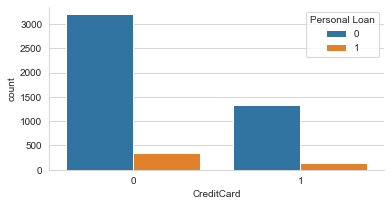

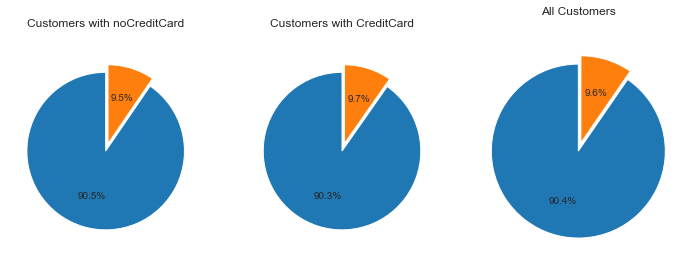

In [22]:
# Analysis of Attribute: CreditCard
curattr = 'CreditCard'
sns.countplot(x = mydata[curattr],hue = 'Personal Loan',data = mydata)
sns.despine()
plt.gcf().set_size_inches(6, 3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4),subplot_kw=dict(aspect="equal"))
plt.axis('equal')

ax1.pie(mydata[mydata[curattr] == 0]['Personal Loan'].value_counts(), autopct= '%1.1f%%', explode = (0, 0.1), radius = 1, startangle = 90)
ax1.set_title('Customers with no'+curattr,fontsize = 12, y = 1.1)
ax2.pie(mydata[mydata[curattr] == 1]['Personal Loan'].value_counts(), autopct= '%1.1f%%',explode = (0, 0.1), radius = 1, startangle = 90)
ax2.set_title('Customers with '+curattr, fontsize = 12, y = 1.1);
ax3.pie(mydata['Personal Loan'].value_counts(), autopct= '%1.1f%%',explode = (0, 0.1), radius = 1, startangle = 90)
ax3.set_title('All Customers', fontsize = 12, y = 1.1);

#### Based on the above we can infer the following - Inference for Attribute: CreditCard

#1.There is a significant overlap of classes for customers who have taken Personal Loan and those who have not taken Personal Loan .
#2.Proportion of customers who take personal loan is almost the same whether the customer has credit card  or not.
#3.Data is skewed towards those without creditcard.




In [23]:
# Analysis of the target: Personal Loan

print(mydata['Personal Loan'].value_counts())
print(mydata['Personal Loan'].value_counts(normalize=True))

0    4520
1     480
Name: Personal Loan, dtype: int64
0    0.904
1    0.096
Name: Personal Loan, dtype: float64


#### Based on the above we can infer the following - Inference for Target: Personal Loan

#1.Class data is heavily skewed for value 0 (i.e customers not taken personal loan). This needs to be balanced


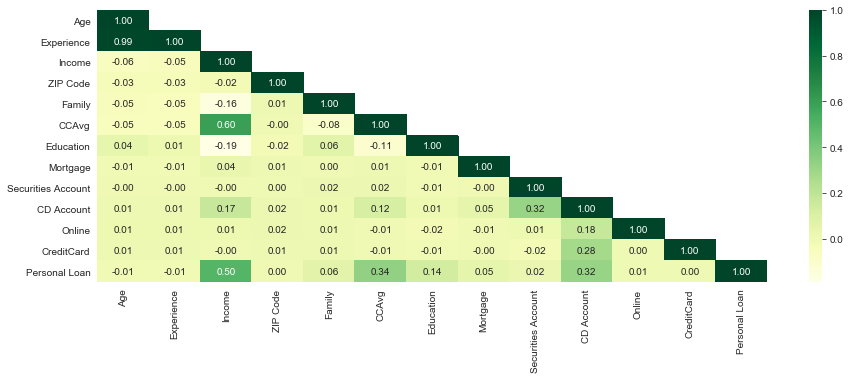

In [24]:
#mydata.corr().round(3)
corr = mydata.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, cmap="YlGn",fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=0)
plt.gcf().set_size_inches(15, 5)

#1. Based on the above, for pairplot analysis, Zipcode can be dropped as this has no impact.
#2. Age and Experience has 99% correlation and hence Experience can be used for further analysis. Age can be dropped.

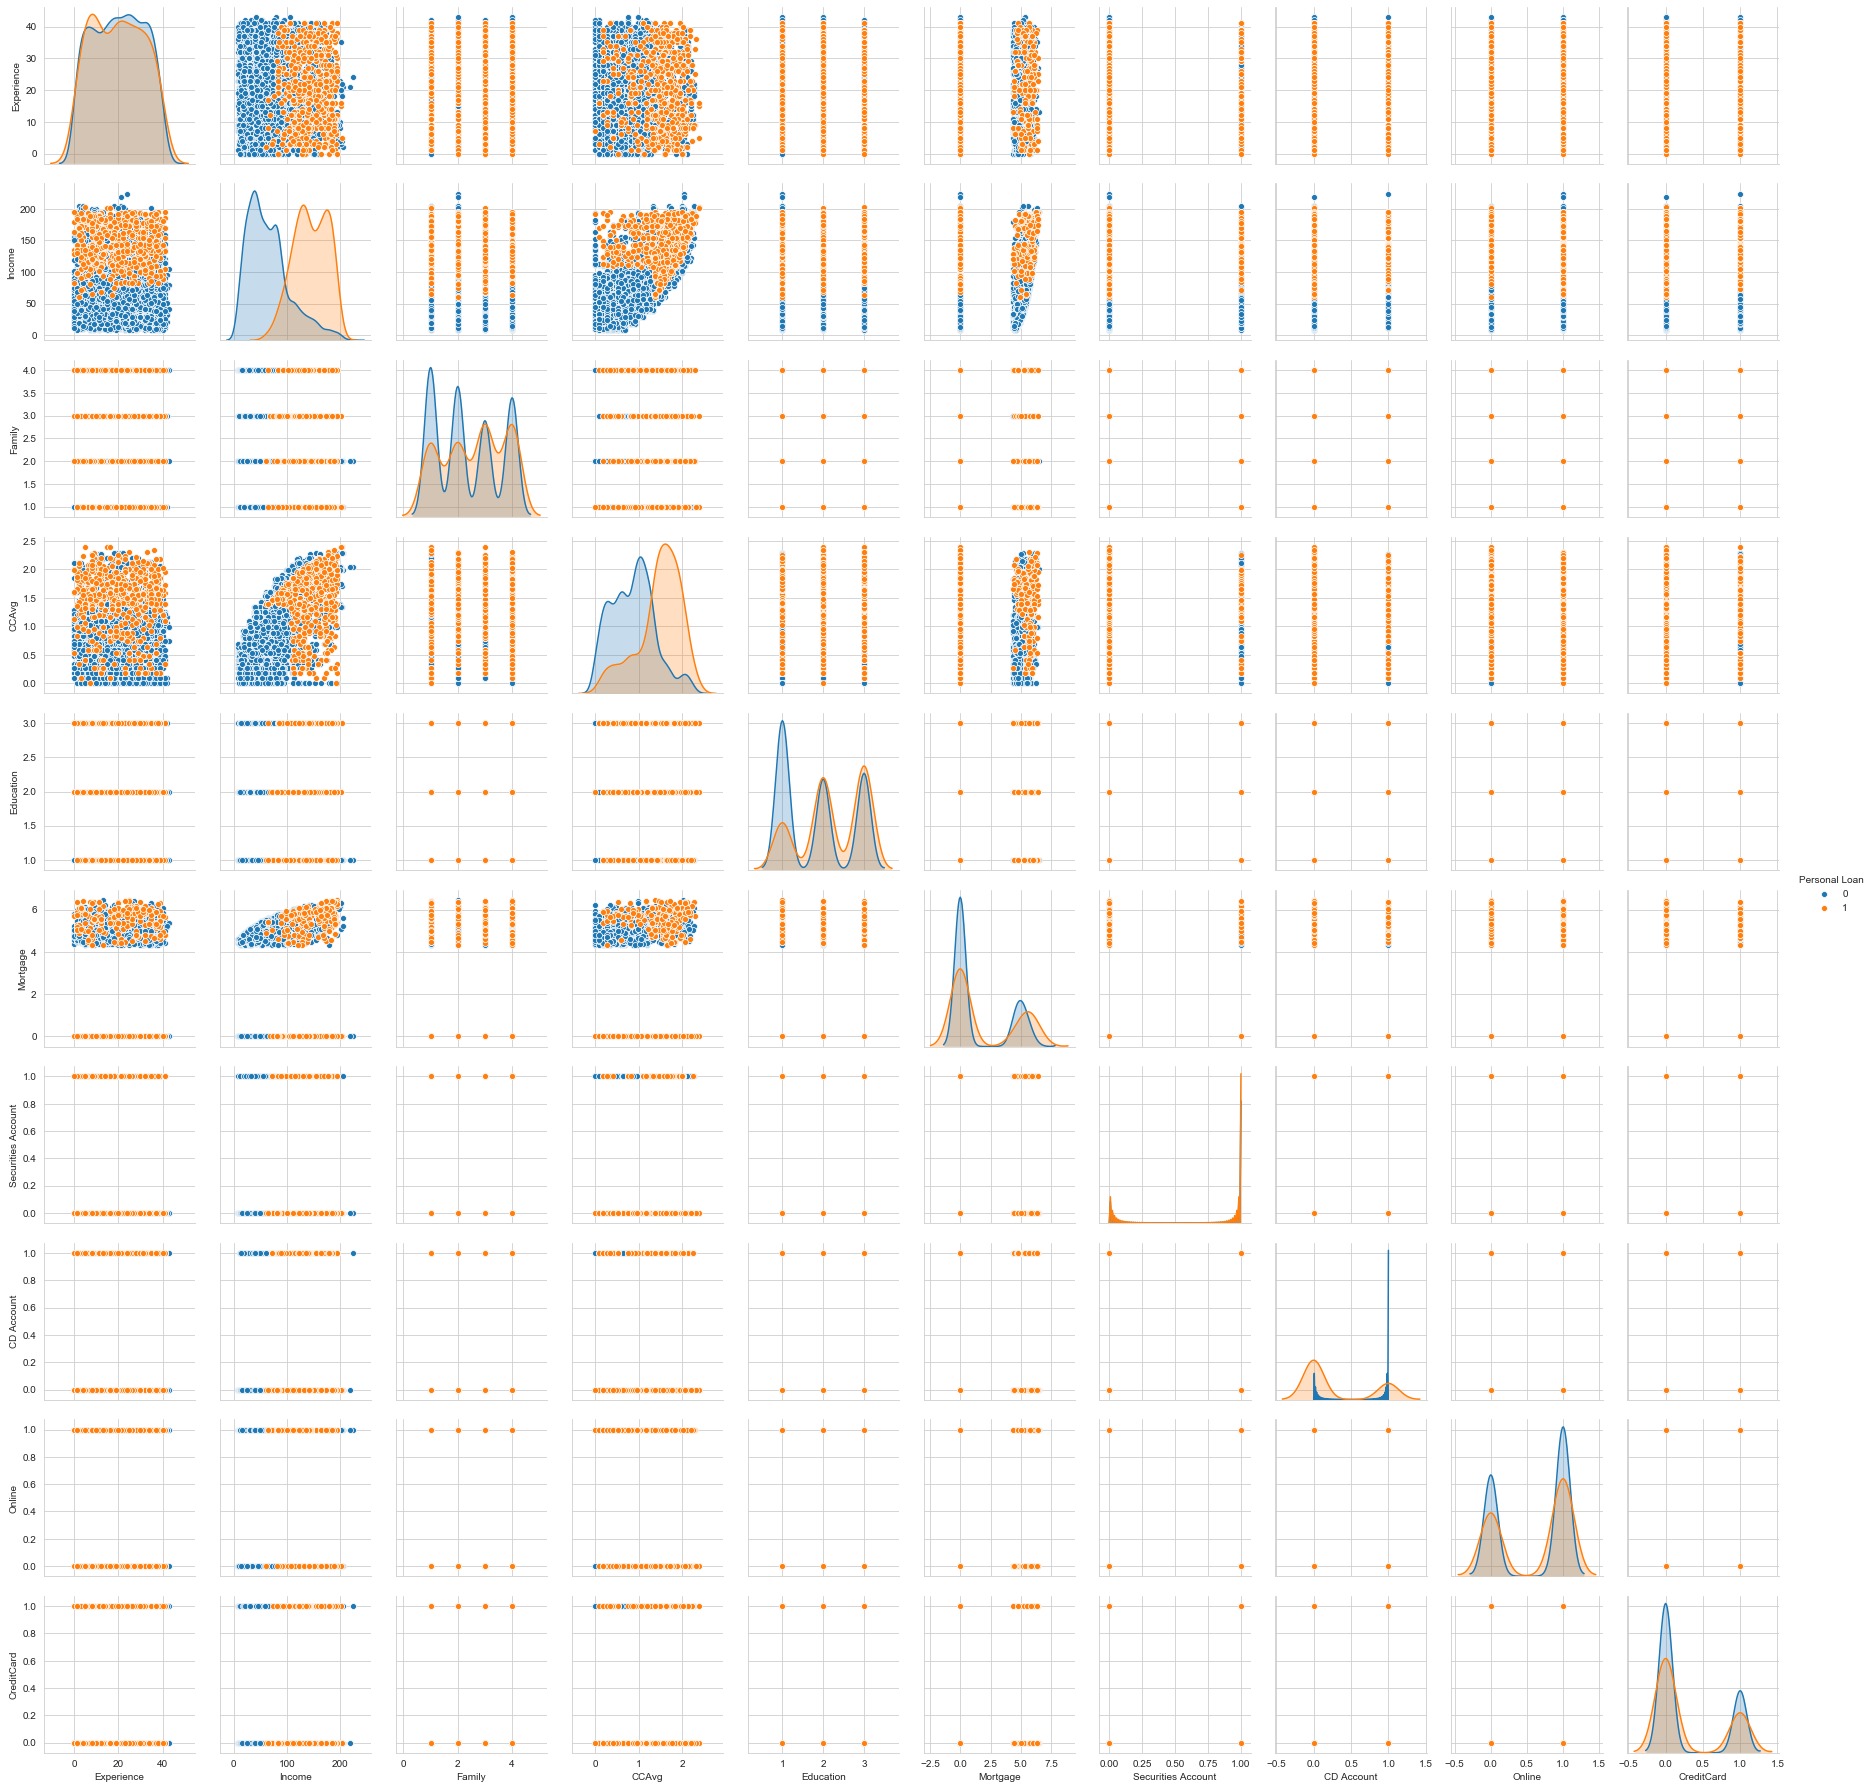

In [25]:
sns.pairplot(data=mydata,vars=['Experience', 'Income', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],hue='Personal Loan')

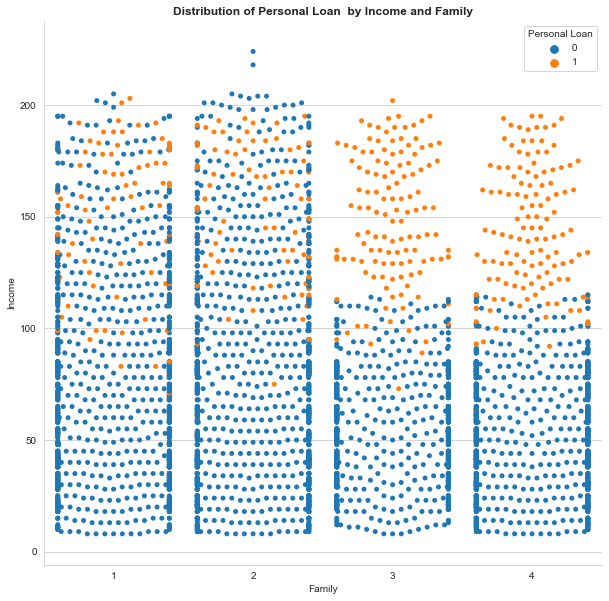

In [26]:
g=sns.swarmplot(mydata['Family'],mydata['Income'],hue ='Personal Loan',data=mydata)
plt.title('Distribution of Personal Loan  by Income and Family',fontweight="bold")
sns.despine()
plt.gcf().set_size_inches(10, 10)

#### Based on the above we can infer the following:

#1. Customers with family size over 2 having higher income range are more likey to take personal loans

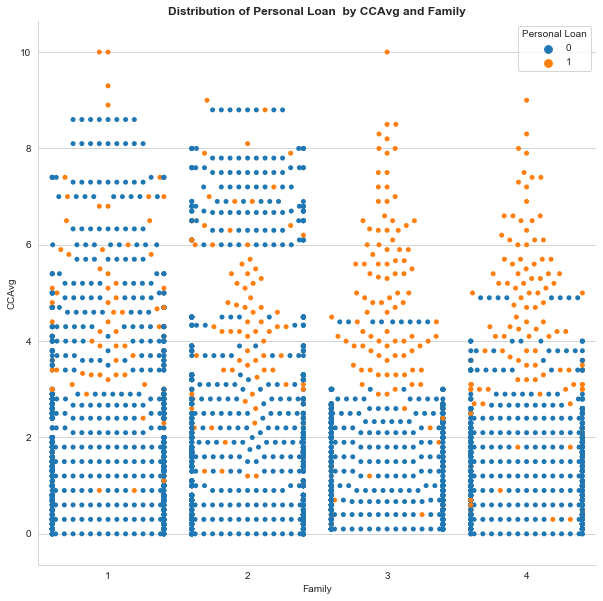

In [27]:
g=sns.swarmplot(rawdata['Family'],rawdata['CCAvg'],hue ='Personal Loan',data=rawdata)
plt.title('Distribution of Personal Loan  by CCAvg and Family',fontweight="bold")
sns.despine()
plt.gcf().set_size_inches(10, 10)

#Anaysis is done on raw data since CCAvg is normalized in mydata dataframe

#### Based on the above we can infer the following:

#1. Customers with family size over 2 having higher CCAvg range are more likey to take personal loans

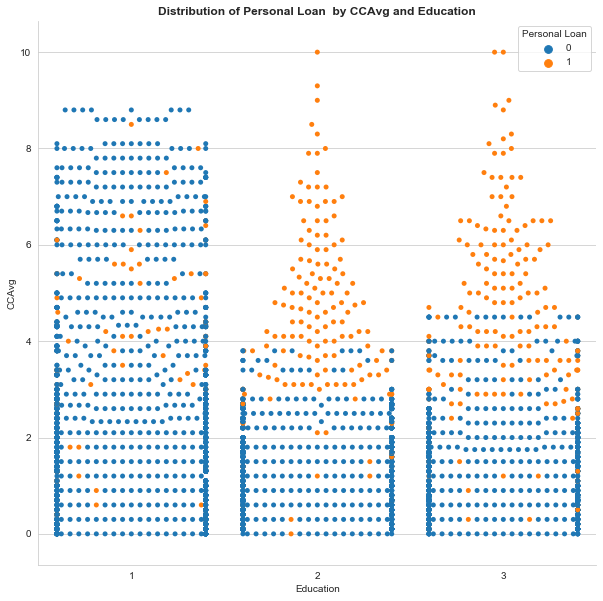

In [28]:
g=sns.swarmplot(rawdata['Education'],rawdata['CCAvg'],hue ='Personal Loan',data=rawdata)
plt.title('Distribution of Personal Loan  by CCAvg and Education',fontweight="bold")
sns.despine()
plt.gcf().set_size_inches(10, 10)

#Anaysis is done on raw data since CCAvg is normalized in mydata dataframe

#### Based on the above we can infer the following:

#1. Customers with education above 1 having higher CCAvg range are more likey to take personal loans

## Feature Analysis and Selection

In [29]:
# Using statsmodel logistic regression to identify the p values for features
mydata2=mydata.drop(['Age','ZIP Code'],axis=1)
mydata2.sample(5)

,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
3607,15,62,3,0.641854,3,0.000000,0,0,0,0,0
3456,22,125,2,1.740466,3,0.000000,0,0,1,0,1
1667,20,22,1,0.693147,1,4.521789,0,0,0,0,0
1671,9,20,4,0.741937,3,0.000000,0,0,1,0,0
2673,30,88,4,0.693147,2,4.812184,0,0,1,0,0


In [30]:
#creating array based on first level filtered data to assign X and y
array=mydata2.values
X=array[:,0:10]
y=array[:,[10]]
#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)
#computing P value of features and coeff for features using statmodel logistic regression
model_logit = sm.Logit(y_train,X_train)
result_logit= model_logit.fit()
result_logit.summary2()

Optimization terminated successfully.
         Current function value: 0.264011
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.160     
Dependent Variable: y                AIC:              1868.0773 
Date:               2019-09-06 21:24 BIC:              1929.6825 
No. Observations:   3500             Log-Likelihood:   -924.04   
Df Model:           9                LL-Null:          -1100.0   
Df Residuals:       3490             LLR p-value:      2.4821e-70
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1       -0.0593     0.0053   -11.1905   0.0000   -0.0697   -0.0490
x2        0.0183     0.0015    12.5833   0.0000    0.0154    0.0211
x3       -0.3651     0.0510    -7.1577   0.0000   -0.4651   -0.2651
x4       -0.5136     0.1223    -4.1995   0.0000   -0.7533   -0.2739
x5       -0.1395     0.0642    -2.1723   0.0298   -0.2654   -0.0136
x6       -0.0984     0.0259    -3.8049   0.0001   -0.1491   -0.0477
x7       -1.6321     0.2568    -6.3554   0.0000   -2.1354   -1.1288
x8        4.4986     0.2692    16.7091   0.0000    3.9709    5.0263
x9       -1.4112     0.1292   -10.9255   0.0000   -1.6644   -1.1581
x10      -1.5571     0.1827    -8.5223   0.0000   -1.9151   -1.1990
=================================================================

"""

In [31]:
#LRSMresult = (result_logit.summary2().tables[1])
LRSMpvalue = pd.DataFrame(result_logit.pvalues)
#LRSMpvalue_filtered = LRSMpvalue[LRSMpvalue['P Value']==0.05]
features = pd.DataFrame(mydata2.columns)
LRSMFeatureScore = pd.concat([features,LRSMpvalue],axis=1)
LRSMFeatureScore.columns = ['Feature','P Value']
LRSMFeatureScore.head(10).round(2)

,Feature,P Value
0,Experience,0.00
1,Income,0.00
2,Family,0.00
3,CCAvg,0.00
4,Education,0.03
5,Mortgage,0.00
6,Securities Account,0.00
7,CD Account,0.00
8,Online,0.00
9,CreditCard,0.00


#1 Based on above , feature to be selected for analysis is those with P value < 0.05
#2 i.e Experience,Income,Family,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,
#3 this analysis shows that all 10 features can be considered relevant for model

In [32]:
# Using RFE for feature selection

mydata2_z = mydata2.apply(zscore)
arrayX=mydata2_z.values
arrayy=mydata2.values
X=arrayX[:,0:10]
y=arrayy[:,[10]]
classifier = LogisticRegression(random_state=0,solver='lbfgs',max_iter=20000)
rfe = RFE(classifier,n_features_to_select =6)
rfe = rfe.fit(X,y.ravel())
rfesupport=pd.DataFrame(rfe.support_)
rferanking=pd.DataFrame(rfe.ranking_)
features=pd.DataFrame(mydata2_z.columns)
RFEFeatureScore=pd.concat([features,rfesupport,rferanking],axis=1)
RFEFeatureScore.columns=['Feature','Support','Ranking']
RFEFeatureScore.sort_values(by='Ranking')


,Feature,Support,Ranking
1,Income,True,1.0
2,Family,True,1.0
3,CCAvg,True,1.0
4,Education,True,1.0
7,CD Account,True,1.0
9,CreditCard,True,1.0
8,Online,False,2.0
6,Securities Account,False,3.0
0,Experience,False,4.0
5,Mortgage,False,5.0


#1. Based on above , feature to be selected for analysis is those with Ranking 1
#2. i.e Income,Family,CCAvg,Education,CD Account,CreditCard

In [33]:
# Using SelectKBest class to extract top 10 features
array=mydata2.values
X=array[:,0:10]
y=array[:,[10]]
bestfeatures = SelectKBest(score_func=chi2,k=10)
fit=bestfeatures.fit(X,y)
SKBscore=pd.DataFrame(fit.scores_)
features=pd.DataFrame(mydata2.columns)
SKBFeatureScore=pd.concat([features,SKBscore],axis=1)
SKBFeatureScore.columns=['Feature','Score']
SKBFeatureScore.nlargest(10,'Score')

,Feature,Score
1,Income,36252.494760
7,CD Account,470.177616
3,CCAvg,172.402873
5,Mortgage,46.400560
4,Education,35.042209
2,Family,10.347204
0,Experience,2.230838
6,Securities Account,2.158275
8,Online,0.079453
9,CreditCard,0.027705


#1. Based on above , feature to be selected for analysis is top 8
#2. i.e Income,CD Account,CC Avg,Education,Mortgage,Family,Securities Account,Experience

In [34]:
#creating dataframe based on various feature selection
#mydata2 dataframe has all 10 features
mydatarfe=mydata2.drop(['Online','Securities Account','Experience','Mortgage'],axis=1)
mydataskb=mydata2.drop(['CreditCard','Online'],axis=1)


## Logistic Regression -  using all 10 features

In [35]:
array=mydata2.values
X=array[:,0:10]
y=array[:,[10]]

#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model
model = LogisticRegression(solver='lbfgs',max_iter=20000)
model.fit(X_train_bal, y_train_bal)
y_predict = model.predict(X_test)


# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

# Updating model evaluation output dataframe

curmodeloutput = {'Model':'LR',                              
                  'Featurebasis':'Z-10',
                  'MCC':mcc,
                  'Accuracy':accuracy_score,
                  'ROCAUC':rocauc,
                  'PRAUC':prauc,
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 

modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

modelevalcompdf.iloc[0,:]


Model                                     LR
Featurebasis                            Z-10
MCC                                 0.636906
Accuracy                               0.906
ROCAUC                              0.963412
PRAUC                               0.812008
CM                  [[1226, 127], [14, 133]]
Class0-Precision                     0.98871
Sensitivity                         0.906135
Class0-F1                           0.945623
Class1-Precision                    0.511538
Specificity                         0.904762
Class1-F1                           0.653563
Name: 0, dtype: object

## Logistic Regression -  using top 8 features identified per SelectKBest

In [36]:

array=mydataskb.values
X=array[:,0:8]
y=array[:,[8]]

#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model
model = LogisticRegression(solver='lbfgs',max_iter=20000)
model.fit(X_train_bal, y_train_bal)
y_predict = model.predict(X_test)


# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

# Updating model evaluation output dataframe

curmodeloutput = {'Model':'LR',                  
                  'Featurebasis':'SKB-8',
                  'MCC':mcc,
                  'Accuracy':accuracy_score,
                  'ROCAUC':rocauc,
                  'PRAUC':prauc,
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 


modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

modelevalcompdf.iloc[1,:]

Model                                     LR
Featurebasis                           SKB-8
MCC                                   0.6264
Accuracy                            0.902667
ROCAUC                              0.959249
PRAUC                               0.792281
CM                  [[1222, 131], [15, 132]]
Class0-Precision                    0.987874
Sensitivity                         0.903178
Class0-F1                           0.943629
Class1-Precision                    0.501901
Specificity                         0.897959
Class1-F1                           0.643902
Name: 1, dtype: object

## Logistic Regression -  using 6 features identified per RFE

In [37]:

array=mydatarfe.values
X=array[:,0:6]
y=array[:,[6]]

#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model
model = LogisticRegression(solver='lbfgs',max_iter=20000)
model.fit(X_train_bal, y_train_bal)
y_predict = model.predict(X_test)


# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

# Updating model evaluation output dataframe

curmodeloutput = {'Model':'LR',                  
                  'Featurebasis':'RFE-6',
                  'MCC':mcc,
                  'Accuracy':accuracy_score,
                  'ROCAUC':rocauc,
                  'PRAUC':prauc,
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 


modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

modelevalcompdf.iloc[2,:]

Model                                     LR
Featurebasis                           RFE-6
MCC                                 0.633825
Accuracy                            0.904667
ROCAUC                              0.960637
PRAUC                               0.803257
CM                  [[1224, 129], [14, 133]]
Class0-Precision                    0.988691
Sensitivity                         0.904656
Class0-F1                           0.944809
Class1-Precision                    0.507634
Specificity                         0.904762
Class1-F1                           0.650367
Name: 2, dtype: object

## Naive Bayes Classifier -  using all 10 features

In [38]:

array=mydata2.values
X=array[:,0:10]
y=array[:,[10]]

#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model
model = GaussianNB()
model.fit(X_train_bal, y_train_bal)
y_predict = model.predict(X_test)


# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

# Updating model evaluation output dataframe

curmodeloutput = {'Model':'NB',                  
                  'Featurebasis':'Z-10',
                  'MCC':mcc,
                  'Accuracy':accuracy_score,
                  'ROCAUC':rocauc,
                  'PRAUC':prauc,
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 



modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

modelevalcompdf.iloc[3,:]

Model                                     NB
Featurebasis                            Z-10
MCC                                 0.566238
Accuracy                            0.887333
ROCAUC                              0.937252
PRAUC                               0.613644
CM                  [[1208, 145], [24, 123]]
Class0-Precision                    0.980519
Sensitivity                         0.892831
Class0-F1                           0.934623
Class1-Precision                    0.458955
Specificity                         0.836735
Class1-F1                           0.592771
Name: 3, dtype: object

## Naive Bayes Classifier -  using 8 features as per SelectKBest

In [39]:

array=mydataskb.values
X=array[:,0:8]
y=array[:,[8]]

#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model
model = GaussianNB()
model.fit(X_train_bal, y_train_bal)
y_predict = model.predict(X_test)



# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

# Updating model evaluation output dataframe

curmodeloutput = {'Model':'NB',                  
                  'Featurebasis':'SKB-8',
                  'MCC':mcc,
                  'Accuracy':accuracy_score,
                  'ROCAUC':rocauc,
                  'PRAUC':prauc,
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 

modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

modelevalcompdf.iloc[4,:]

Model                                     NB
Featurebasis                           SKB-8
MCC                                 0.566512
Accuracy                               0.886
ROCAUC                              0.936764
PRAUC                               0.610764
CM                  [[1205, 148], [23, 124]]
Class0-Precision                     0.98127
Sensitivity                         0.890613
Class0-F1                           0.933747
Class1-Precision                    0.455882
Specificity                         0.843537
Class1-F1                           0.591885
Name: 4, dtype: object

## Naive Bayes Classifier -  using 6 features as per RFE

In [40]:

array=mydatarfe.values
X=array[:,0:6]
y=array[:,[6]]

#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Train and test the model
model = GaussianNB()
model.fit(X_train_bal, y_train_bal)
y_predict = model.predict(X_test)



# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

# Updating model evaluation output dataframe

curmodeloutput = {'Model':'NB',                  
                  'Featurebasis':'RFE-6',
                  'MCC':mcc,
                  'Accuracy':accuracy_score,
                  'ROCAUC':rocauc,
                  'PRAUC':prauc,
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 

modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

modelevalcompdf.iloc[5,:]

Model                                     NB
Featurebasis                           RFE-6
MCC                                 0.562399
Accuracy                               0.884
ROCAUC                              0.935176
PRAUC                               0.604686
CM                  [[1202, 151], [23, 124]]
Class0-Precision                    0.981224
Sensitivity                         0.888396
Class0-F1                           0.932506
Class1-Precision                    0.450909
Specificity                         0.843537
Class1-F1                           0.587678
Name: 5, dtype: object

## KNN - using all 10 features

In [41]:
array=mydata2.values
X=array[:,0:10]
y=array[:,[10]]

#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Finding optimal value for K ( based on MCE)

knnlist =list(range(1,10))
krange= list(filter(lambda x:x%2!=0, knnlist))
kacscores=[]

for k in krange:
    knn=KNeighborsClassifier(n_neighbors=k,weights='distance')
    knn.fit(X_train,y_train.ravel())
    y_pred=knn.predict(X_test)
    scores=metrics.accuracy_score(y_test,y_pred)
    kacscores.append(scores)
    
MSE=[1-x for x in kacscores]
optimalk=knnlist[MSE.index(min(MSE))]

print('The optimal value for k is %d' %optimalk)


# Train and test the model
model = KNeighborsClassifier(n_neighbors=optimalk,weights='distance')
model.fit(X_train_bal, y_train_bal)
y_predict = model.predict(X_test)


# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

# Updating model evaluation output dataframe

curmodeloutput = {'Model':'KNN',
                  'Featurebasis':'Z-10',
                  'MCC':mcc,
                  'Accuracy':accuracy_score,
                  'ROCAUC':rocauc,
                  'PRAUC':prauc,
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 

modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

modelevalcompdf.iloc[6,:]

The optimal value for k is 1


Model                                   KNN
Featurebasis                           Z-10
MCC                                0.835508
Accuracy                           0.971333
ROCAUC                             0.911346
PRAUC                              0.859466
CM                  [[1334, 19], [24, 123]]
Class0-Precision                   0.982327
Sensitivity                        0.985957
Class0-F1                          0.984139
Class1-Precision                   0.866197
Specificity                        0.836735
Class1-F1                          0.851211
Name: 6, dtype: object

## KNN - using  8 features as per SKB

In [42]:
array=mydataskb.values
X=array[:,0:8]
y=array[:,[8]]

#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Finding optimal value for K ( based on MCE)

knnlist =list(range(1,10))
krange= list(filter(lambda x:x%2!=0, knnlist))
kacscores=[]

for k in krange:
    knn=KNeighborsClassifier(n_neighbors=k,weights='distance')
    knn.fit(X_train,y_train.ravel())
    y_pred=knn.predict(X_test)
    scores=metrics.accuracy_score(y_test,y_pred)
    kacscores.append(scores)
    
MSE=[1-x for x in kacscores]
optimalk=knnlist[MSE.index(min(MSE))]

print('The optimal value for k is %d' %optimalk)


# Train and test the model
model = KNeighborsClassifier(n_neighbors=optimalk,weights='distance')
model.fit(X_train_bal, y_train_bal)
y_predict = model.predict(X_test)


# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

# Updating model evaluation output dataframe

curmodeloutput = {'Model':'KNN',                  
                  'Featurebasis':'SKB-8',
                  'MCC':mcc,
                  'Accuracy':accuracy_score,
                  'ROCAUC':rocauc,
                  'PRAUC':prauc,
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 

modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

modelevalcompdf.iloc[7,:]

The optimal value for k is 1


Model                                   KNN
Featurebasis                          SKB-8
MCC                                0.856452
Accuracy                           0.975333
ROCAUC                             0.913563
PRAUC                              0.878573
CM                  [[1340, 13], [24, 123]]
Class0-Precision                   0.982405
Sensitivity                        0.990392
Class0-F1                          0.986382
Class1-Precision                   0.904412
Specificity                        0.836735
Class1-F1                          0.869258
Name: 7, dtype: object

## KNN - using  6 features as per RFE

In [43]:
array=mydatarfe.values
X=array[:,0:6]
y=array[:,[6]]

#creating train test split
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.3,random_state=9)

# Feature Scaling
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# Class balancing using SMOTE
sm = SMOTE(random_state=9)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train.ravel())

# Finding optimal value for K ( based on MCE)

knnlist =list(range(1,10))
krange= list(filter(lambda x:x%2!=0, knnlist))
kacscores=[]

for k in krange:
    knn=KNeighborsClassifier(n_neighbors=k,weights='distance')
    knn.fit(X_train,y_train.ravel())
    y_pred=knn.predict(X_test)
    scores=metrics.accuracy_score(y_test,y_pred)
    kacscores.append(scores)
    
MSE=[1-x for x in kacscores]
optimalk=knnlist[MSE.index(min(MSE))]

print('The optimal value for k is %d' %optimalk)


# Train and test the model
model = KNeighborsClassifier(n_neighbors=optimalk,weights='distance')
model.fit(X_train_bal, y_train_bal)
y_predict = model.predict(X_test)


# Model evaluation

accuracy_score = metrics.accuracy_score(y_test,y_predict)
recall_score = metrics.recall_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
precision_score = metrics.precision_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
f1_score = metrics.f1_score(y_test,y_predict,labels=None,pos_label=1,average=None,sample_weight=None)
matrix=metrics.confusion_matrix(y_test,y_predict)
mcc = metrics.matthews_corrcoef(y_test, y_predict, sample_weight=None)

# ROC AUC score
probs = model.predict_proba(X_test)
probs = probs[:,1]
rocauc = metrics.roc_auc_score(y_test,probs)

# Precision Recall AUC score
precision,recall,thresholds = metrics.precision_recall_curve(y_test,probs)
prauc = metrics.auc(recall,precision)

# Updating model evaluation output dataframe

curmodeloutput = {'Model':'KNN',                  
                  'Featurebasis':'RFE-6',
                  'MCC':mcc,
                  'Accuracy':accuracy_score,
                  'ROCAUC':rocauc,
                  'PRAUC':prauc,
                  'CM':matrix,
                  'Class0-Precision':precision_score[0],
                  'Sensitivity':recall_score[0],
                  'Class0-F1':f1_score[0],
                  'Class1-Precision':precision_score[1],
                  'Specificity':recall_score[1],
                  'Class1-F1':f1_score[1]} 

modelevalcompdf = modelevalcompdf.append(curmodeloutput,ignore_index=True)

modelevalcompdf.iloc[8,:]

The optimal value for k is 1


Model                                   KNN
Featurebasis                          RFE-6
MCC                                0.875942
Accuracy                              0.978
ROCAUC                             0.939296
PRAUC                              0.893479
CM                  [[1336, 17], [16, 131]]
Class0-Precision                   0.988166
Sensitivity                        0.987435
Class0-F1                            0.9878
Class1-Precision                   0.885135
Specificity                        0.891156
Class1-F1                          0.888136
Name: 8, dtype: object

## Comparison of Model evaluation metrices

In [44]:
modelevalcompdf.style.set_table_styles([dict(selector='th',props=[('text-align','center')])]).hide_index()\
                    .highlight_max(axis=0)\
                    .format("{:.3}",subset=['MCC','Accuracy','ROCAUC','PRAUC','Class0-Precision','Sensitivity'
                                            ,'Class0-F1','Class1-Precision','Specificity','Class1-F1'])

Model,Featurebasis,MCC,Accuracy,ROCAUC,PRAUC,CM,Class0-Precision,Sensitivity,Class0-F1,Class1-Precision,Specificity,Class1-F1
LR,Z-10,0.637,0.906,0.963,0.812,[[1226 127] [ 14 133]],0.989,0.906,0.946,0.512,0.905,0.654
LR,SKB-8,0.626,0.903,0.959,0.792,[[1222 131] [ 15 132]],0.988,0.903,0.944,0.502,0.898,0.644
LR,RFE-6,0.634,0.905,0.961,0.803,[[1224 129] [ 14 133]],0.989,0.905,0.945,0.508,0.905,0.65
NB,Z-10,0.566,0.887,0.937,0.614,[[1208 145] [ 24 123]],0.981,0.893,0.935,0.459,0.837,0.593
NB,SKB-8,0.567,0.886,0.937,0.611,[[1205 148] [ 23 124]],0.981,0.891,0.934,0.456,0.844,0.592
NB,RFE-6,0.562,0.884,0.935,0.605,[[1202 151] [ 23 124]],0.981,0.888,0.933,0.451,0.844,0.588
KNN,Z-10,0.836,0.971,0.911,0.859,[[1334 19] [ 24 123]],0.982,0.986,0.984,0.866,0.837,0.851
KNN,SKB-8,0.856,0.975,0.914,0.879,[[1340 13] [ 24 123]],0.982,0.99,0.986,0.904,0.837,0.869
KNN,RFE-6,0.876,0.978,0.939,0.893,[[1336 17] [ 16 131]],0.988,0.987,0.988,0.885,0.891,0.888


#### Conclusion

#1.Model comparison above shows comparison of results for 3 models ( Logistic Regression, Naive Bayes and KNN)- 'Model' Column.
#2.Each of the models is evaluated with 3 variants of features list selected based on different method. This also shows count of features used in each of these 3 methods - 'Featurebasis' Column.
    #2.1. Z-10 refers to 10 features namely Income,CD Account,CC Avg,Education,Mortgage,Family,Securities Account,Experience,Creditcard,Online selected using z score using logit.
    #2.2. SKB-8 refers to 8 features namely Income,CD Account,CC Avg,Education,Mortgage,Family,Securities Account,Experience selected using SelectKBasis method.
    #2.3. RFE-6 refers to 6 features namely Income,CD Account,CC Avg,Education,Family,Creditcard selected using RFE method.
#3.MCC stands for Matthews Correlation Coeffecient and KNN model with 6 features (RFE) scores highest.
#4.Accuracy is also highest in the KNN model with 6 features (RFE). This is evident from the fact that false observations are the least (17+16 = 33) among all model variants.
#5.ROC AUC is highest in Logistic Regression model with 10 features.
#6.Precision Recall AUC is also calculated and KNN model with 6 features (RFE) scores highest as the highest correct observation among Class 0. 
#7.Confusion Matrix shows that lowest rate of total False observations (FP+FN) is in KNN model with 6 features (RFE). However Logistic regression has the lowest case of FP (cases where model predicted customer will not take loan but the customer has actually taken loan).
#8.Precision (Class 0) is highest in Logistic Regression model with 10 features. However KNN model with 6 features is very close next.
#9.Sensitivity (Class 0 Recall) is highest in KNN model with 8 features (SKB).However KNN model with 6 features(RFE) is very close next.
#10.F1 score for Class 0 and Class 1 is highest in KNN model with 6 features (RFE)
#11.Specificity ( which is very important for the case in point as it denotes the proportion of correct prediction of customer taking loan) is highest in Logistic Regression models , however KNN model with 6 features(RFE) is only marginally behind. 133 were precited correctly to take personal loan while 131 in KNN model with 6 features (RFE).Further , only in 14 cases Logistic Regression model incorrectly classified as not taking personal loan while the customer has actually taken customer loan. KNN Model with 6 features (RFE) predicted 16 such cases. If this is the only point that is considered significant, then Logistic Regression with 10 features is likely to perform better. 
#12.However, overall, KNN model with 6 features (RFE) is likely to perform better ( with 131 correct predictions of customers taking customer loan, which is only 2 units below Logistic Regression model). This model has highest F1 ratio, Accuracy,MCC and also lowest total false observations (FP/FN).

